# INIT

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerias

In [43]:
!pip install featuretools # install the missing module # No lo vamos a usar esta vez

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
from modules import feature_creation_module as fcm

## Importacion datos

### CSVs

In [77]:
# 1. Load and preprocess dataset
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('daily_sales_with_events.csv')

/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering/modules/get_data.py:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [78]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [79]:
# Seleccionar solo años 2014 a 2016 de df_ws
df_ws = df_ws[(df_ws['year'] >= 2014) & (df_ws['year'] <= 2016)]

# df_ws_origin = df_ws.copy() # Para recuperar eventos

# Cambiamos NaN de event por None
df_ws['event'] = df_ws['event'].fillna('None')

In [80]:
df_ws.shape

(9693001, 12)

In [81]:
df_ws.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
8857275,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear
8857276,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear
8857277,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear
8857278,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear
8857279,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear


## Functions

In [82]:
# Creacion caracteristicas
import featuretools as ft

def features_creation(df_items, df_shops, df_ws_select, target):
  # Crear un EntitySet
  es = ft.EntitySet(id='sales_data')

  # Agregar entidades
  es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
  es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
  es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_select,
                        index="id", make_index=True, time_index="date")

  # Definir relaciones
  es = es.add_relationship("items", "item", "sales", "item")
  es = es.add_relationship("shops", "store_code", "sales", "store_code")

  # Generar características automáticas, ahora centradas en target
  feature_matrix, feature_defs = ft.dfs(entityset=es,
                                        target_dataframe_name=target,  # Objetivo: target
                                        agg_primitives=[
                                            "min",
                                            "max",
                                            "std",
                                            "sum",
                                            "mean",
                                            "count"
                                        ],
                                        trans_primitives=[],  # Simple
                                        max_depth=2)

  print("--------------------------------------------------------------------------------------------")
  print(f"Feature Matrix shape {feature_matrix.shape}")

  return feature_matrix

In [83]:
# Preprocesamiento
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

def preprocess_data(feature_matrix):
  # Nos quedamos de feature_matrix solo las columnas numericas
  ftm_to_scale = feature_matrix.select_dtypes(include=[np.number])

  # display(ftm_to_scale.head())

  # ftm_scaled = StandardScaler().fit_transform(ftm_to_scale)
  ftm_scaled = RobustScaler().fit_transform(ftm_to_scale) # Probamos con Robust
  ftm_scaled = pd.DataFrame(ftm_scaled, columns=ftm_to_scale.columns)

  display(ftm_scaled.describe())
  return ftm_scaled

In [84]:
from sklearn.decomposition import PCA
def perform_pca2D(data, n_components=2):
  # 2. Reduce the dimensions using Principal Component Analysis (PCA)
  pca_2 = PCA(n_components=2)
  pca_2_result = pca_2.fit_transform(data)

  print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

  print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
  return pca_2, pca_2_result

In [85]:
def find_imp_features(pca_2, data):
  # 3. Finding important features with the help of PCA
  # Results from pca.components_
  dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=data.columns, index=['PC_1', 'PC_2'])

  # display(dataset_pca.T)
  return dataset_pca

In [86]:
def show_imp_features(data_pca, imp_thresh):
  # Most important features
  print("\n*************** Most important features *************************")
  print('As per PC 1:\n', (data_pca[data_pca > imp_thresh].iloc[0]).dropna())
  print('\n\nAs per PC 2:\n', (data_pca[data_pca > imp_thresh].iloc[1]).dropna())
  print("\n******************************************************************")

In [87]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

def hyperparameter_tuning(data):
  # 4. Hyperparameter tuning using the silhouette score method
  # candidate values for our number of cluster
  parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]

  # instantiating ParameterGrid, pass number of clusters as input
  parameter_grid = ParameterGrid({'n_clusters': parameters})
  best_score = -1
  kmeans_model = KMeans()     # instantiating KMeans model
  silhouette_scores = []

  # evaluation based on silhouette_score
  for p in parameter_grid:
      kmeans_model.set_params(**p)    # set current hyper parameter
      kmeans_model.fit(data)          # fit model on main dataset, this will find clusters based on parameter p
      ss = metrics.silhouette_score(data, kmeans_model.labels_)   # calculate silhouette_score
      silhouette_scores += [ss]       # store all the scores
      print('Parameter:', p, 'Score', ss)
      # check p which has the best score
      if ss > best_score:
          best_score = ss
          best_grid = p

  # plotting silhouette score
  plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
  plt.xticks(range(len(silhouette_scores)), list(parameters))
  plt.title('Silhouette Score', fontweight='bold')
  plt.xlabel('Number of Clusters')
  plt.show()

  return best_grid, best_score

In [140]:
def apply_kmeans(data, best_grid, n_clusters=None):
  # 5. Apply K Means
  if n_clusters: # Para poder probar otras combinaciones
    optimum_num_clusters = n_clusters
  else:
    optimum_num_clusters = best_grid['n_clusters']

  # fitting KMeans
  kmeans = KMeans(n_clusters=optimum_num_clusters)
  kmeans.fit(data)
  return kmeans

In [89]:
def get_centroids_and_df_labeled(kmeans, data):
  # Obtenemos los centroids de kmeans
  centroids = kmeans.cluster_centers_

  # Obtenemos los labels de los clusters de kmeans
  labels = kmeans.labels_

  # Aplicamos estos labels al df original
  data['cluster'] = labels
  return centroids, labels, data

*Note*: In the code, the fit_transform method of PCA is not applied to KMeans. That is because of 2 main reasons:

1.  We would like to reduce the dimensions so that we can visualize our data in 2-D. Reducing dimensions also means some loss of information.
2.  To apply our KMeans we cannot ignore the information which was lost when we reduced the dimensions, hence we should apply KMeans on the entire scaled data.

In [90]:
def plot_clusters(pca_2_result, labels, centroids):
  # Graficar los puntos de PCA con los clusters y los centroides
  plt.figure(figsize=(10, 6))

  # Graficar puntos de cada cluster, usando los labels obtenidos de KMeans
  for cluster in np.unique(labels):
      plt.scatter(pca_2_result[labels == cluster, 0], pca_2_result[labels == cluster, 1],
                  label=f'Cluster {cluster}', s=50, alpha=0.6)

  # Graficar los centroides obtenidos del modelo KMeans en las coordenadas PCA
  centroids_pca = pca_2.transform(centroids)  # Transformar los centroides de KMeans con PCA
  plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
              s=200, c='red', marker='X', label='Centroides')

  # Añadir títulos y etiquetas
  plt.title('Product clusters', fontsize=14)
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')

  # Añadir leyenda
  plt.legend()

  # Mostrar el gráfico
  plt.show()

In [91]:
def show_clusters_info(kmeans, data_scaled):
  # Explicacion / Descripcion de los clusters
  # Centroides en el espacio original de las características
  centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=data_scaled.columns)
  display(centroids_df)

  # Describir los clusters basados en los centroides
  for i, centroid in centroids_df.iterrows():
      print(f"\nCluster {i}:")
      print(centroid.sort_values(ascending=False).head(5))  # Mostrar las 5 características más representativas

  return centroids_df

In [92]:
'''
Para garantizar que los clusters están bien definidos y diferenciados, el análisis
de la silueta te ayudará a entender la cohesión interna de cada grupo y qué tan
separados están los clusters entre sí.
'''
from sklearn.metrics import silhouette_samples
def validate_clusters(data_scaled, labels):
  silhouette_vals = silhouette_samples(data_scaled, labels)

  # Promedio de la silueta por cluster
  silhouette_avg = silhouette_vals.mean()
  print(f"Promedio del coeficiente de silueta: {silhouette_avg}")
  return silhouette_avg, silhouette_vals

In [93]:
# Visualizacion num de items x cluster
def plot_cluster_items(data_labeled):
  ax = sns.countplot(x='cluster', data=data_labeled, order=data_labeled['cluster'].value_counts().index)

  # Calcular el total de ítems
  total_items = len(data_labeled)

  # Añadir los porcentajes y totales encima de cada barra
  for p in ax.patches:
      count = p.get_height()  # obtener el número de ítems por barra
      percentage = 100 * count / total_items  # calcular el porcentaje
      # Añadir el texto con porcentaje y total (porcentaje y cifra en paréntesis)
      ax.text(p.get_x() + p.get_width() / 2., count + 0.1,
              '{:.1f}% ({})'.format(percentage, count),
              ha='center', va='bottom')

  # Mostrar el gráfico
  plt.show()

# Productos  01  
  
> https://medium.com/swlh/k-means-clustering-on-high-dimensional-data-d2151e1a4240

## Creacion de caracteristicas

In [133]:
# Reiniciamos datasets
items = df_items.copy()
shops = df_shops.copy()
df_ws_select = df_ws.copy()
# Seleccionamos solo las necesarias para featuretools y relacionadas con ventas
df_ws_select = df_ws[['item', 'date', 'store_code', 'units', 'raw_earn']]

In [134]:
feature_matrix = features_creation(items, shops, df_ws_select, target='items')

display(feature_matrix.head())

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

--------------------------------------------------------------------------------------------
Feature Matrix shape (3049, 14)


,category,department,cluster,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),SUM(sales.units)
item,,,,,,,,,,,,,,
ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,1,2515,65.9148,6.0,15.315095,1.393241,6.6500,1.0,7.921939,0.720229,38517.4650,3504.0
ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0,1750,31.6806,6.0,6.694430,1.268571,2.6600,1.0,3.270445,0.618826,11715.2518,2220.0
ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0,1176,23.7006,6.0,4.806321,1.220238,1.2901,1.0,2.159986,0.548854,5652.2340,1435.0
ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,0,5241,123.4240,20.0,21.065210,3.413471,6.1712,1.0,17.589802,2.850305,110402.7680,17890.0
ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0,3854,34.4736,9.0,6.509380,1.704463,2.6600,1.0,3.881594,1.010506,25087.1516,6569.0


### Preprocesamiento

In [135]:
ftm_scaled = preprocess_data(feature_matrix)

,cluster,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),SUM(sales.units)
count,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.0,3049.000000,3049.000000,3049.000000,3049.000000
mean,0.164644,0.128407,0.456139,0.665042,0.385387,0.674109,0.317902,0.0,0.462924,0.592218,0.527259,0.666985
std,0.370920,0.670008,1.883064,2.296725,1.505298,2.406492,0.968924,0.0,2.006190,2.036305,1.959973,2.352621
min,0.000000,-1.058934,-1.043144,-0.714286,-1.076195,-0.675265,-0.765241,0.0,-1.090200,-0.809809,-0.747709,-0.613501
25%,0.000000,-0.418168,-0.372928,-0.285714,-0.370948,-0.333652,-0.302114,0.0,-0.366392,-0.344726,-0.343257,-0.306874
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.581832,0.627072,0.714286,0.629052,0.666348,0.697886,0.0,0.633608,0.655274,0.656743,0.693126
max,1.000000,2.097222,42.120199,42.428571,29.714804,51.409196,8.376377,0.0,52.167054,33.166613,36.449474,45.630687


## Clustering

In [141]:
# Dim redux
pca_2, pca_2_result = perform_pca2D(ftm_scaled)

Explained variation per principal component: [0.66131683 0.21567305]
Cumulative variance explained by 2 principal components: 87.70%


In [142]:
# Visualizacion Imp caracteristicas por PCA
# Importancia de caracteristicas por PCA
dataset_pca = find_imp_features(pca_2, ftm_scaled)

IMP_THRESH = 0.3
show_imp_features(dataset_pca, imp_thresh=IMP_THRESH)


*************** Most important features *************************
As per PC 1:
 MAX(sales.units)       0.367109
MEAN(sales.units)      0.460037
STD(sales.units)       0.382845
SUM(sales.raw_earn)    0.333696
SUM(sales.units)       0.438105
Name: PC_1, dtype: float64


As per PC 2:
 MAX(sales.raw_earn)     0.403094
MAX(sales.units)        0.318482
MEAN(sales.raw_earn)    0.391899
STD(sales.raw_earn)     0.486954
SUM(sales.raw_earn)     0.328159
Name: PC_2, dtype: float64

******************************************************************


Parameter: {'n_clusters': 2} Score 0.7903575849150131
Parameter: {'n_clusters': 3} Score 0.6274538168319529
Parameter: {'n_clusters': 4} Score 0.5939491123317481
Parameter: {'n_clusters': 5} Score 0.5645991782458416
Parameter: {'n_clusters': 10} Score 0.35655068051322053
Parameter: {'n_clusters': 15} Score 0.2785941640221051
Parameter: {'n_clusters': 20} Score 0.26515812313204284
Parameter: {'n_clusters': 25} Score 0.22990892242188918
Parameter: {'n_clusters': 30} Score 0.23488601025633346
Parameter: {'n_clusters': 35} Score 0.22632671704082352
Parameter: {'n_clusters': 40} Score 0.21004159163458788


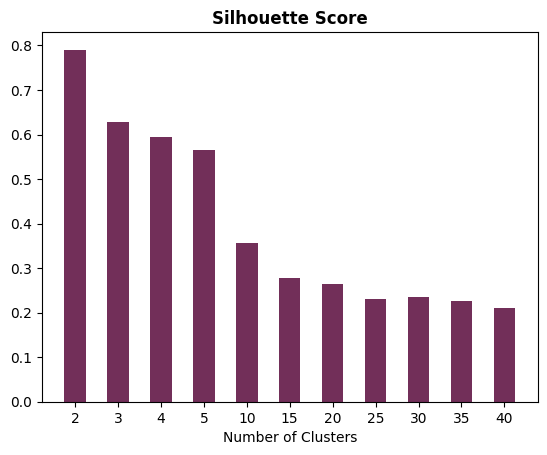

In [143]:
# Apply Kmeans

# Hyperparam tuning based on Silhouette -> optimum num of clusters
best_grid, best_score = hyperparameter_tuning(ftm_scaled)

kmeans = apply_kmeans(ftm_scaled, best_grid)
# kmeans = apply_kmeans(ftm_scaled, best_grid, 3) # Por probar con otros n_clusters

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


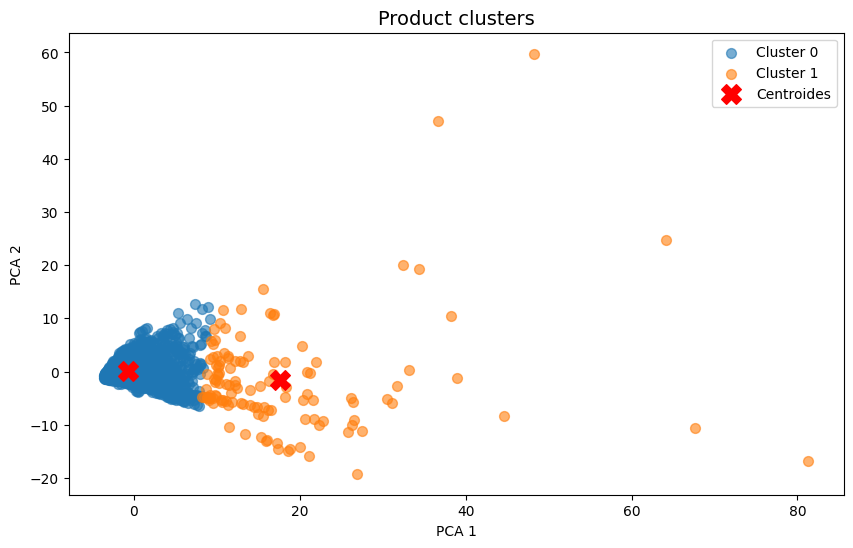

In [144]:
# Visualizacion 2D clusters
centroids, labels, df_items_labeled = get_centroids_and_df_labeled(kmeans, items)

plot_clusters(pca_2_result, labels, centroids)

In [145]:
# Ver df de centroides para explicacion
centroids_df = show_clusters_info(kmeans, ftm_scaled)

,cluster,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),SUM(sales.units)
0,0.166097,0.079158,0.268994,0.343253,0.264037,0.326447,0.333220,0.0,0.277211,0.288368,0.311371,0.339613
1,0.130081,1.299955,4.908041,8.319977,3.272138,8.944490,-0.046505,0.0,4.880789,7.820402,5.662931,8.454719



Cluster 0:
MAX(sales.units)       0.343253
SUM(sales.units)       0.339613
MIN(sales.raw_earn)    0.333220
MEAN(sales.units)      0.326447
SUM(sales.raw_earn)    0.311371
Name: 0, dtype: float64

Cluster 1:
MEAN(sales.units)      8.944490
SUM(sales.units)       8.454719
MAX(sales.units)       8.319977
STD(sales.units)       7.820402
SUM(sales.raw_earn)    5.662931
Name: 1, dtype: float64


In [146]:
# Validacion clusters con silhouette
silhouette_avg, silhouette_vals = validate_clusters(ftm_scaled, labels)

Promedio del coeficiente de silueta: 0.7903575849150131


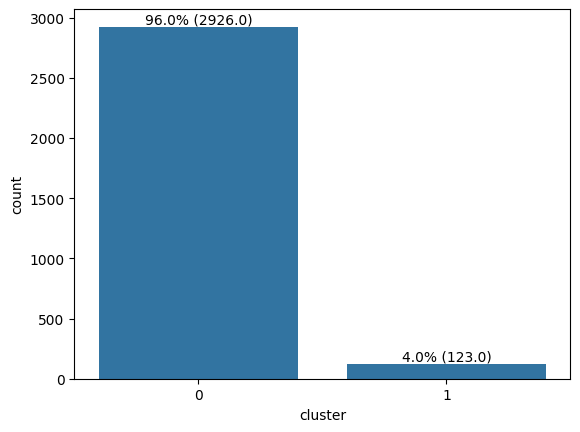

In [147]:
# Clusters vs Num de items
plot_cluster_items(df_items_labeled)

# Productos  02 - Rango de precios

## Creacion de caracteristicas

In [104]:
# Reiniciamos datasets
items = df_items.copy()
shops = df_shops.copy()
df_ws_select = df_ws.copy()
# Seleccionamos solo las necesarias para featuretools y relacionadas con ventas
# Version simple
# cols_to_select = ['item', 'store_code', 'units', 'sell_price', 'raw_earn']
cols_to_select = ['item', 'date', 'store_code', 'sell_price']
df_ws_select = df_ws_select[cols_to_select]

In [105]:
feature_matrix = features_creation(items, shops, df_ws_select, target='items')

display(feature_matrix.head())

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

--------------------------------------------------------------------------------------------
Feature Matrix shape (3049, 9)


,category,department,cluster,COUNT(sales),MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price)
item,,,,,,,,,
ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2515,11.4646,10.991607,6.6500,0.155606,27643.8904
ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0,1750,5.2801,5.276346,2.6600,0.094061,9233.6048
ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0,1176,3.9501,3.943246,1.2502,0.135582,4637.2578
ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,0,5241,6.1712,6.171200,6.1712,0.000000,32343.2592
ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0,3854,4.0964,3.815668,2.6600,0.143314,14705.5839


### Preprocesamiento

In [106]:
ftm_scaled = preprocess_data(feature_matrix)

,cluster,COUNT(sales),MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price)
count,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000
mean,0.040341,0.128407,0.306987,0.298526,0.325574,0.375951,0.308325
std,0.196790,0.670008,1.033884,0.980789,0.967038,1.157763,1.115291
min,0.000000,-1.058934,-0.861058,-0.856369,-0.736686,-0.366643,-0.932112
25%,0.000000,-0.418168,-0.341544,-0.339615,-0.295858,-0.366643,-0.381880
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.581832,0.658456,0.660385,0.704142,0.633357,0.618120
max,1.000000,2.097222,12.078801,7.511326,8.431977,16.809226,10.319810


## Clustering

In [107]:
# Dim redux
pca_2, pca_2_result = perform_pca2D(ftm_scaled)

Explained variation per principal component: [0.64242342 0.16982363]
Cumulative variance explained by 2 principal components: 81.22%


In [108]:
# Visualizacion Imp caracteristicas por PCA
# Importancia de caracteristicas por PCA
dataset_pca = find_imp_features(pca_2, ftm_scaled)

IMP_THRESH = 0.3
show_imp_features(dataset_pca, imp_thresh=IMP_THRESH)


*************** Most important features *************************
As per PC 1:
 MAX(sales.sell_price)     0.508142
MEAN(sales.sell_price)    0.477697
MIN(sales.sell_price)     0.424764
STD(sales.sell_price)     0.370720
SUM(sales.sell_price)     0.438675
Name: PC_1, dtype: float64


As per PC 2:
 STD(sales.sell_price)    0.809952
SUM(sales.sell_price)    0.470493
Name: PC_2, dtype: float64

******************************************************************


Parameter: {'n_clusters': 2} Score 0.5400912838430574
Parameter: {'n_clusters': 3} Score 0.3967160999260347
Parameter: {'n_clusters': 4} Score 0.23478694214855997
Parameter: {'n_clusters': 5} Score 0.251425100905665
Parameter: {'n_clusters': 10} Score 0.24453543764480684
Parameter: {'n_clusters': 15} Score 0.2544693715264172
Parameter: {'n_clusters': 20} Score 0.25838937454992267
Parameter: {'n_clusters': 25} Score 0.2547175735696305
Parameter: {'n_clusters': 30} Score 0.24699318551692823
Parameter: {'n_clusters': 35} Score 0.24921844694685155
Parameter: {'n_clusters': 40} Score 0.2388425590404032


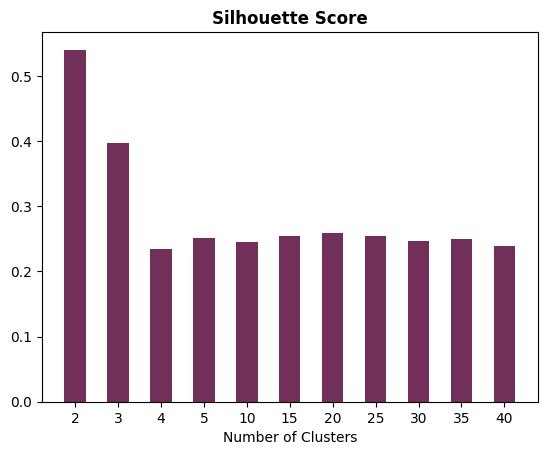

In [109]:
# Apply Kmeans

# Hyperparam tuning based on Silhouette -> optimum num of clusters
best_grid, best_score = hyperparameter_tuning(ftm_scaled)

kmeans = apply_kmeans(ftm_scaled, best_grid)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


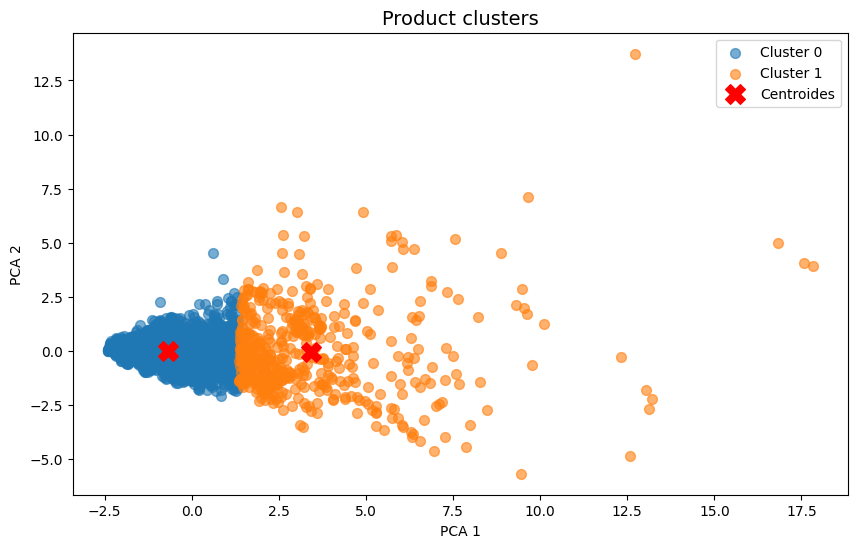

In [110]:
# Visualizacion 2D clusters
centroids, labels, df_items_labeled = get_centroids_and_df_labeled(kmeans, items)

plot_clusters(pca_2_result, labels, centroids)

In [111]:
# Ver df de centroides para explicacion
centroids_df = show_clusters_info(kmeans, ftm_scaled)

,cluster,COUNT(sales),MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price)
0,0.042010,0.164765,-0.035808,-0.027889,0.031104,0.134022,0.01322
1,0.031873,-0.056063,2.046227,1.954664,1.819631,1.603430,1.80560



Cluster 0:
COUNT(sales)             0.164765
STD(sales.sell_price)    0.134022
cluster                  0.042010
MIN(sales.sell_price)    0.031104
SUM(sales.sell_price)    0.013220
Name: 0, dtype: float64

Cluster 1:
MAX(sales.sell_price)     2.046227
MEAN(sales.sell_price)    1.954664
MIN(sales.sell_price)     1.819631
SUM(sales.sell_price)     1.805600
STD(sales.sell_price)     1.603430
Name: 1, dtype: float64


In [112]:
# Validacion clusters con silhouette
silhouette_avg, silhouette_vals = validate_clusters(ftm_scaled, labels)

Promedio del coeficiente de silueta: 0.5400912838430574


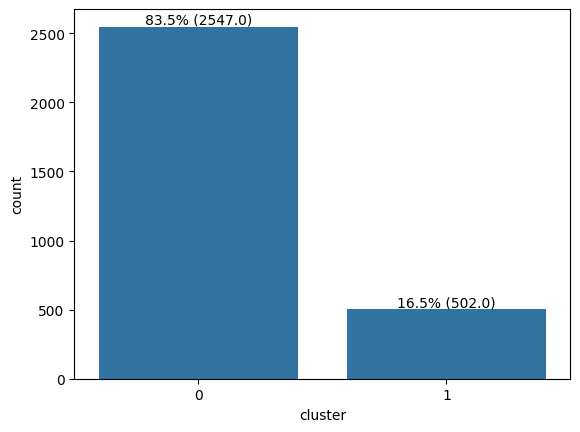

In [113]:
# Clusters vs Num de items
plot_cluster_items(df_items_labeled)